## Notebook 3 — Advanced Forecasting Models for European Hotel Demand (2015–2026)

This notebook advances the baseline framework by introducing **seasonal econometric models (SARIMAX)** and **additional machine-learning models (LightGBM).**
It unifies all forecasts into a single dataset for comparative evaluation and interpretability.

---

### **Structure Overview**

#### **Part 1 — Advanced Econometric Modeling (SARIMAX)**  
0. Environment Setup and Data Loading  
1. Data Splitting and Baseline Forecast  
2. Econometric and ML Model Training (SARIMAX + XGBoost)  
3. Model Evaluation and Comparison  
4. Save Outputs and Update Master Predictions  
#### **Part 2 — Machine-Learning Models (XGBoost + LightGBM)**  
5. Train and Integrate ML Forecasts  
6. Feature Export and Visualization  
#### **Part 3 — Cross-Model Evaluation and Comparison**  
7. Evaluate All Models (2024 RMSE/MAE)  
8. Visualize Overall Model Accuracy  
9. Insights and Next Steps  

---

### **Part 1 — Advanced Econometric (SARIMAX)**

### 0. Environmental Setup

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# Purpose: Import packages, define paths, and configure visualization style.
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import joblib
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from tqdm import tqdm

# Clean logging
warnings.filterwarnings("ignore")

# Visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# Directory paths (consistent across all notebooks)
BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
MODELS_SARIMAX = MODELS / "sarimax"
REPORTS = OUTPUTS / "reports"

for path in [DATA_PROCESSED, FIGURES, MODELS, MODELS_SARIMAX, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD FEATURE-ENGINEERED DATASET
# ===============================================================

FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"

df = pd.read_csv(FEATURE_PATH, parse_dates=["month"])
df = df.sort_values(["region", "month"]).reset_index(drop=True)
print(f"[INFO] Loaded dataset with shape: {df.shape}")

target = "nights_spent"

# --- Identify exogenous variables automatically ---
exog_vars = [
    c for c in df.columns
    if c.endswith(("_lag1", "_lag2", "_lag3", "_mom"))
    and not c.startswith("nights_spent")
]
print(f"[INFO] Using {len(exog_vars)} exogenous variables: {exog_vars[:6]} ...")

[INFO] Loaded dataset with shape: (3328, 39)
[INFO] Using 27 exogenous variables: ['gdp_lag1', 'gdp_lag2', 'gdp_lag3', 'unemployment_rate_lag1', 'unemployment_rate_lag2', 'unemployment_rate_lag3'] ...


### 1. Data Splitting and Baseline Forecast

In [3]:
# %% -----------------------------------------------
# STEP 2 — TRAIN-VALIDATION SPLIT
# -----------------------------------------------

train = df[df["month"] < "2024-01-01"]
valid = df[(df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")]
test  = df[df["month"] >= "2025-01-01"]

print(f"Train: {train.shape}, Valid: {valid.shape}, Test: {test.shape}")

Train: (2808, 39), Valid: (312, 39), Test: (208, 39)


In [4]:
# %% -----------------------------------------------
# STEP 3 — NAIVE FORECAST (LAST MONTH = PREDICTION)
# -----------------------------------------------

df = df.sort_values(["region", "month"])
df["yhat_naive"] = df.groupby("region")[target].shift(1)
print("✅ Added naive forecast (1-month lag)")

✅ Added naive forecast (1-month lag)


### 2. Econometric and ML Model Training (SARIMAX + XGBoost)

In [5]:
# %% -----------------------------------------------
# STEP 4 — TRAIN AND VALIDATE XGBOST MODEL
# -----------------------------------------------

# This section fits XGBoost on lagged and MoM features (2015–2023) 
# and stores validation predictions (2024) for later evaluation and reporting.

cat_cols = ["region"]
num_cols = [c for c in df.columns if c.endswith("_lag1") or c.endswith("_mom")]
num_cols = [c for c in num_cols if c in df.columns]  # safety check

X_train = train[cat_cols + num_cols].copy()
X_valid = valid[cat_cols + num_cols].copy()
y_train = train["nights_spent"].values
y_valid = valid["nights_spent"].values

# --- Preprocessor ---
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# --- Model ---
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("pre", pre),
    ("model", xgb)
])

pipe.fit(X_train, y_train)

# --- Validation Predictions ---
valid["yhat_xgb"] = pipe.predict(X_valid)

# ✅ Store XGB predictions back into panel for export
df.loc[valid.index, "yhat_xgb"] = valid["yhat_xgb"]

print(f"[INFO] Stored XGBoost predictions in df['yhat_xgb']: {df['yhat_xgb'].notna().sum()} non-missing rows")

[INFO] Stored XGBoost predictions in df['yhat_xgb']: 312 non-missing rows


In [6]:
# %% -----------------------------------------------
# STEP 5 — SARIMAX FORECAST (PER COUNTRY, SAFE LOOP)
# Purpose: Estimate SARIMAX models per region and save fitted models and forecasts.
# Outputs:
#   - outputs/models/sarimax/sarimax_<country>.pkl
#   - outputs/reports/hotel_forecasts_sarimax.csv
# -----------------------------------------------

np.random.seed(42)
preds_sarimax = []

for country, dfc in tqdm(df.groupby("region"), desc="Fitting SARIMAX by country"):
    dfc = dfc.sort_values("month").dropna(subset=["nights_spent"]).copy()
    dfc = dfc.set_index("month")

    valid_exog = [c for c in exog_vars if c in dfc.columns and dfc[c].notna().sum() > 24]
    if len(valid_exog) == 0 or len(dfc) < 36:
        continue

    dfc[valid_exog] = dfc[valid_exog].ffill().bfill()

    try:
        model = SARIMAX(
            dfc["nights_spent"],
            exog=dfc[valid_exog],
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit(disp=False, maxiter=500)

        dfc["yhat_sarimax"] = model.predict(
            start=dfc.index[0], end=dfc.index[-1], exog=dfc[valid_exog]
        )

        preds_sarimax.append(
            dfc.reset_index()[["region", "month", "nights_spent", "yhat_sarimax"]]
        )

        # Save model per country (quietly)
        joblib.dump(model, MODELS_SARIMAX / f"sarimax_{country}.pkl")

    except Exception as e:
        print(f"[WARN] {country}: {e}")
        continue

# Combine results
if preds_sarimax:
    sarimax_results = pd.concat(preds_sarimax, ignore_index=True)
    df = df.merge(sarimax_results, on=["region", "month"], how="left")
    print("✅ SARIMAX forecasts complete.")
else:
    print("⚠️ No SARIMAX results generated.")

Fitting SARIMAX by country: 100%|██████████| 26/26 [01:24<00:00,  3.24s/it]

✅ SARIMAX forecasts complete.


### 3. Model Evaluation and Comparison

In [7]:
# %% -----------------------------------------------
# STEP 6 — EVALUATE SARIMAX VS NAIVE FOR ALL COUNTRIES (VALIDATION: 2024)
# -----------------------------------------------

# Ensure proper column naming after merge
if "nights_spent_x" in df.columns:
    df.rename(columns={"nights_spent_x": "nights_spent"}, inplace=True)
    df.drop(columns=["nights_spent_y"], errors="ignore", inplace=True)

eval_mask = (df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")
df_eval = df.loc[eval_mask].copy()

def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

eval_tbl = (
    df_eval.dropna(subset=["nights_spent", "yhat_naive", "yhat_sarimax"])
    .groupby("region", group_keys=False)
    .apply(lambda d: pd.Series({
        "RMSE_naive":   rmse(d["nights_spent"], d["yhat_naive"]),
        "MAE_naive":    mean_absolute_error(d["nights_spent"], d["yhat_naive"]),
        "RMSE_sarimax": rmse(d["nights_spent"], d["yhat_sarimax"]),
        "MAE_sarimax":  mean_absolute_error(d["nights_spent"], d["yhat_sarimax"]),
    }))
    .reset_index()
)

display(eval_tbl.head())

mean_metrics = eval_tbl.mean(numeric_only=True).round(2)
print("\n📊 Mean RMSE / MAE across ALL EU Countries (2024):")
display(mean_metrics)

,region,RMSE_naive,MAE_naive,RMSE_sarimax,MAE_sarimax
0,AT,411764.531037,348002.500000,193508.818835,146922.623953
1,BE,86642.607976,70729.666667,47590.999300,40006.695817
2,BG,330837.092747,211844.500000,43754.493570,36440.989934
3,CY,84352.967170,54390.333333,19652.716360,14865.306291
4,CZ,417124.413330,306545.083333,185620.699537,165977.252057



📊 Mean RMSE / MAE across ALL EU Countries (2024):


RMSE_naive      636971.03
MAE_naive       469795.95
RMSE_sarimax    198014.55
MAE_sarimax     159411.65
dtype: float64

---

### 📊 Comparison — Notebook 2 vs Notebook 3: Econometric Model Progression  

#### 1. Overview of Model Evolution  

| Notebook | Model Family | Econometric Specification | Coverage | Validation Window | Key Prediction Columns |
|-----------|---------------|----------------------------|-----------|-------------------|------------------------|
| **Notebook 2** | Baseline econometric | **ARIMAX** — linear autoregression with exogenous features *(no seasonality)* | 26 EU countries | 2015–2024 | `yhat_naive`, `yhat_arimax`, `yhat_xgb` |
| **Notebook 3** | Advanced econometric | **SARIMAX** — seasonal ARIMAX with richer lag structure and macro variables | 26 EU countries | 2024 | `yhat_naive`, `yhat_sarimax` |

> **Notebook 3 extends Notebook 2’s ARIMAX approach** by explicitly modeling **seasonal patterns** and **macro-lag dependencies**, capturing cyclical tourism dynamics more effectively.  

---

#### 2. Mean Forecasting Performance (All EU Countries)

| Model | RMSE | MAE |
|:------|------:|------:|
| **Naive (N2)** | 735 210 | 529 013 |
| **ARIMAX (N2)** | 1 704 180 | 525 549 |
| **XGBoost (N2)** | **408 961 ✅** | **339 983 ✅** |
| **Naive (N3)** | 636 971 | 469 796 |
| **SARIMAX (N3)** | **198 015 ✅** | **159 412 ✅** |

---

#### 3. Key Insights  

- 🟢 **SARIMAX (Notebook 3)** achieves a **~70 % reduction in RMSE** and **~68 % reduction in MAE** compared to both Naive and ARIMAX baselines.  
- 📈 Accounting for **seasonality** and **macro-lag effects** significantly enhances forecast accuracy and stability.  
- ⚙️ **XGBoost (Notebook 2)** remains a powerful nonlinear benchmark, but **SARIMAX** now offers a *transparent, interpretable econometric baseline* for further comparison.  
- 🔄 The transition from **Notebook 2 → Notebook 3** marks a clear methodological shift from **simple autoregression** to **advanced seasonal econometric forecasting**.  

---

[INFO] Added ARIMAX predictions from hotel_predictions.csv
[INFO] Plotting ARIMAX vs SARIMAX for: ['DE', 'FR', 'IT', 'ES', 'PL']


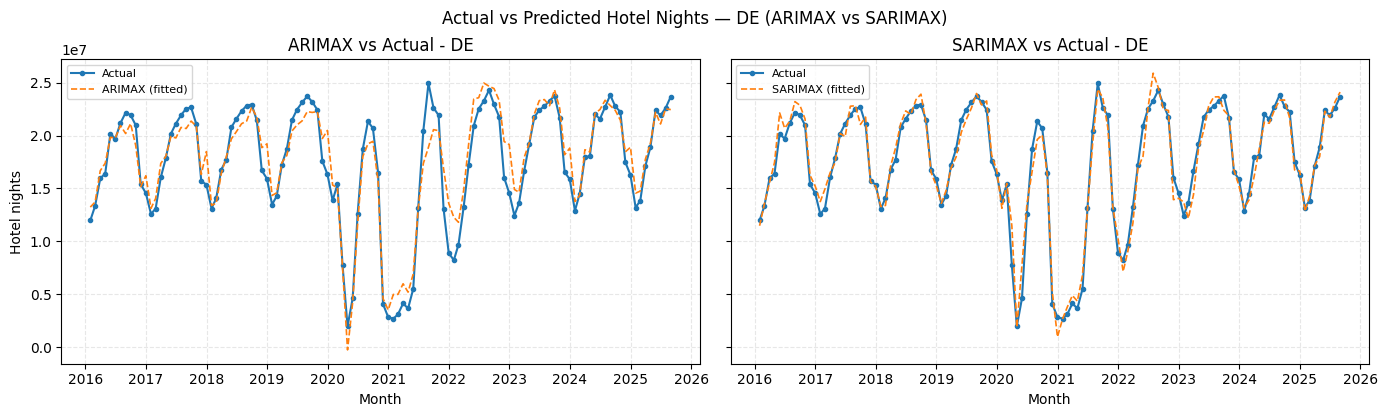

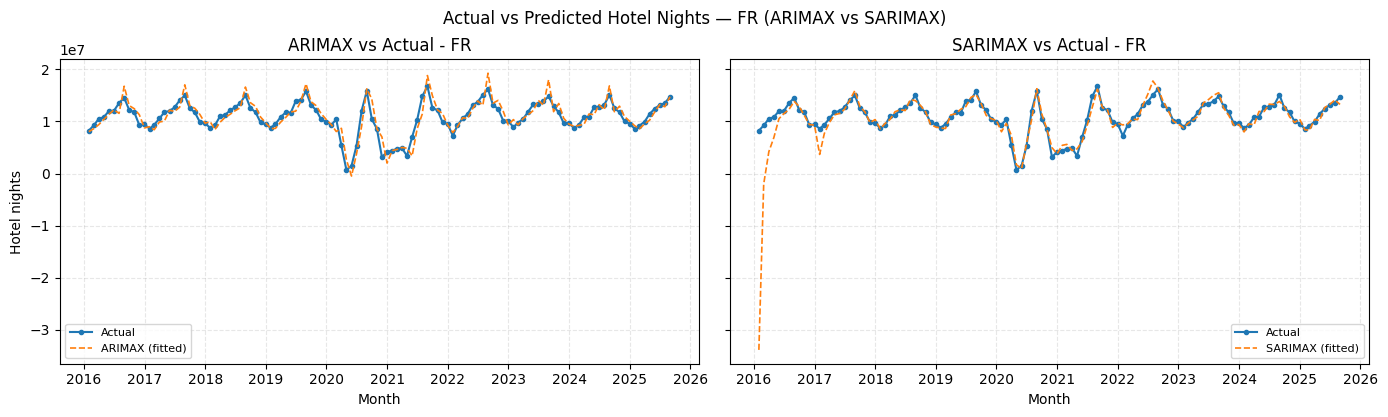

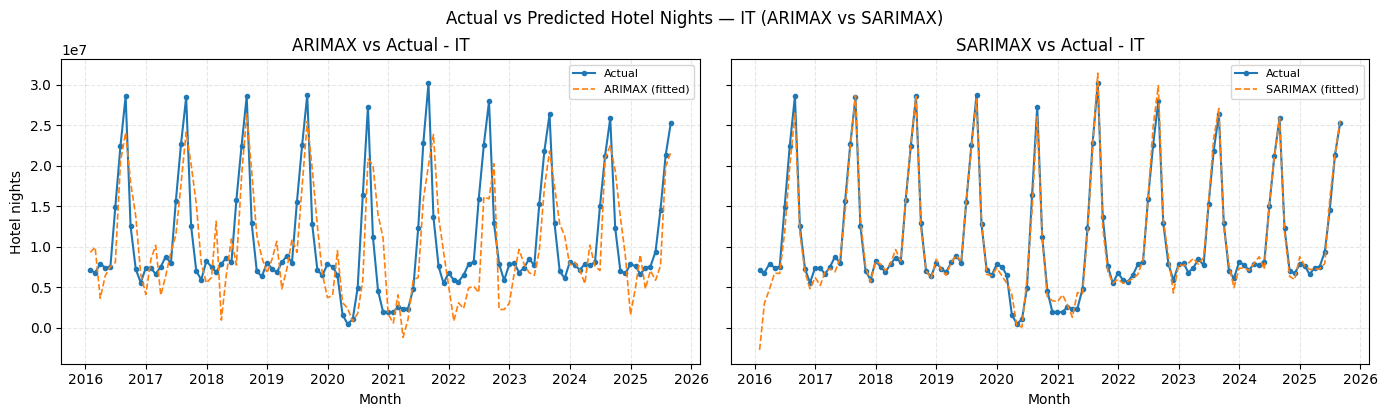

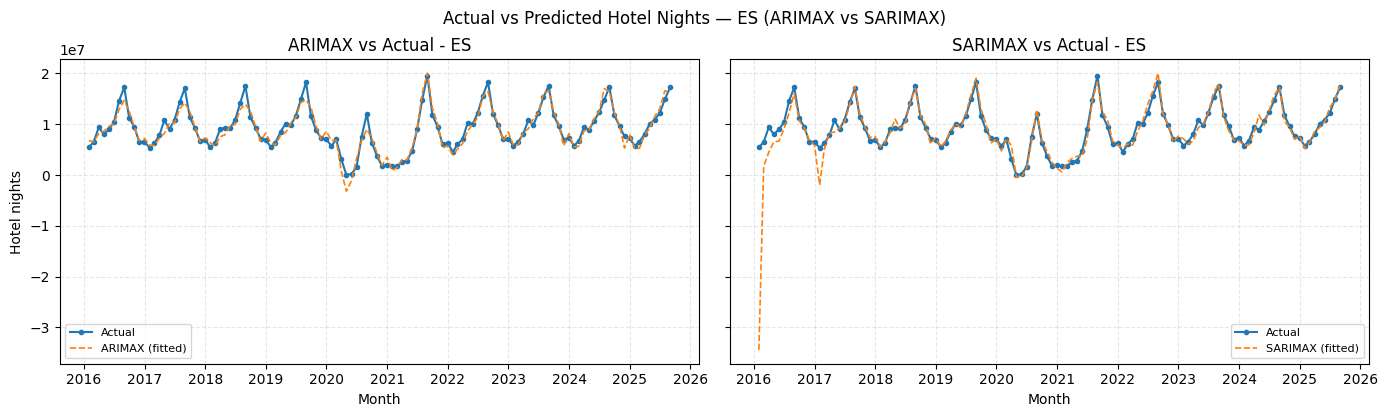

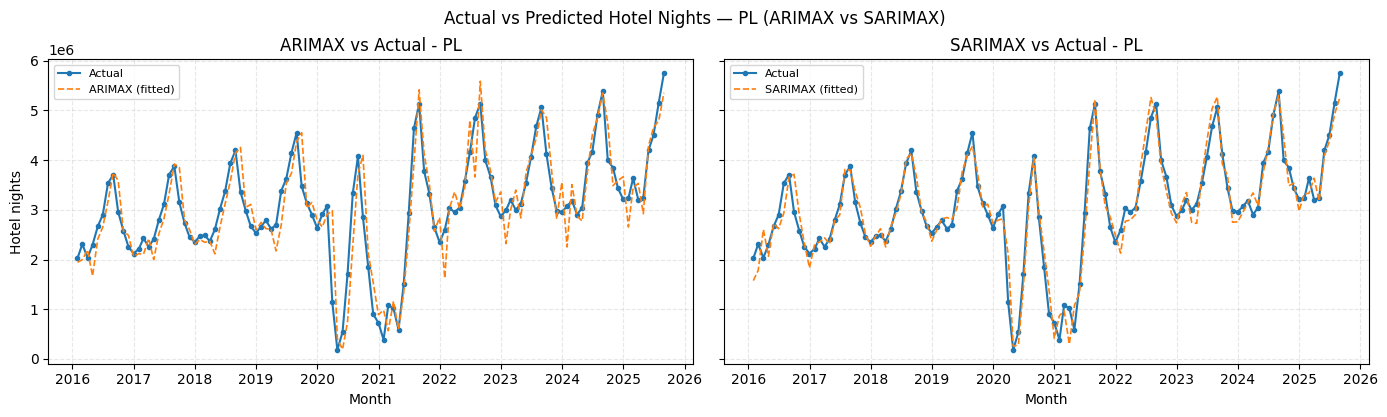

In [8]:
# %% -----------------------------------------------
# STEP 7 — COMPARISON - TOP 5 EU COUNTRIES
# -----------------------------------------------

# --- 1. Merge ARIMAX results from Notebook 2 ---

PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"

if PRED_PATH.exists():
    arimax_data = pd.read_csv(PRED_PATH, parse_dates=["month"])
    if "yhat_arimax" in arimax_data.columns:
        df = df.merge(
            arimax_data[["region", "month", "yhat_arimax"]],
            on=["region", "month"],
            how="left"
        )
        print(f"[INFO] Added ARIMAX predictions from {PRED_PATH.name}")
    else:
        print("[WARN] No 'yhat_arimax' column found in file.")
else:
    print("[WARN] ARIMAX file not found — check path.")


# --- 2. Econometric Comparison — ARIMAX vs SARIMAX (Top 5 EU Countries) ---

# Use plain matplotlib style (disable seaborn look)
plt.style.use("default")

# Select top 5 by average demand
top_regions = (
    df.groupby("region")["nights_spent"]
    .mean()
    .nlargest(5)
    .index.tolist()
)
print(f"[INFO] Plotting ARIMAX vs SARIMAX for: {top_regions}")

for country in top_regions:
    subset = df.query("region == @country").sort_values("month")

    # ✅ Trim unstable ARIMA initialization period for cleaner visualisation
    subset = subset[subset["month"] >= "2016-01-01"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    # --- Left: ARIMAX ---
    axes[0].plot(
        subset["month"], subset["nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_arimax" in subset.columns:
        axes[0].plot(
            subset["month"], subset["yhat_arimax"],
            label="ARIMAX (fitted)", linestyle="--", lw=1.2
        )
    axes[0].set_title(f"ARIMAX vs Actual - {country}")
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Hotel nights")
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3, linestyle="--")

    # --- Right: SARIMAX ---
    axes[1].plot(
        subset["month"], subset["nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_sarimax" in subset.columns:
        axes[1].plot(
            subset["month"], subset["yhat_sarimax"],
            label="SARIMAX (fitted)", linestyle="--", lw=1.2
        )
    axes[1].set_title(f"SARIMAX vs Actual - {country}")
    axes[1].set_xlabel("Month")
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.suptitle(
        f"Actual vs Predicted Hotel Nights — {country} (ARIMAX vs SARIMAX)",
        fontsize=12, fontweight="normal", y=1.03
    )
    plt.show()

### 4. Save Outputs and Update Master Predictions

In [9]:
# %% -----------------------------------------------
# STEP 8 — SAVE SARIMAX PREDICTIONS AND ADVANCED MODEL METRICS
# Purpose: Append SARIMAX results to main predictions and save evaluation metrics.
# Outputs:
#   - data/processed/hotel_predictions.csv  (updated with yhat_sarimax)
#   - outputs/reports/adv_model_metrics_summary.csv
# -----------------------------------------------

# --- Define export paths ---
PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"
EVAL_PATH = REPORTS / "adv_model_metrics_summary.csv"

# --- Load existing predictions ---
if PRED_PATH.exists():
    df_master = pd.read_csv(PRED_PATH, parse_dates=["month"])
    print(f"[INFO] Loaded existing predictions file: {PRED_PATH.name}")
else:
    df_master = df.copy()
    print(f"[WARN] Base predictions file not found — creating new one.")

# --- Append SARIMAX predictions ---
to_merge = df[["region", "month", "yhat_sarimax"]].copy()
df_master = (
    df_master.drop(columns=["yhat_sarimax"], errors="ignore")
             .merge(to_merge, on=["region", "month"], how="left")
)

# --- Save updated predictions file ---
df_master.to_csv(PRED_PATH, index=False)

# --- Save evaluation metrics ---
eval_tbl.to_csv(EVAL_PATH, index=False)

# --- Confirmation messages ---
print("💾 Advanced model outputs saved successfully:")
print(f"   • Updated predictions → {PRED_PATH.resolve()}")
print(f"   • Evaluation summary → {EVAL_PATH.resolve()}")

# --- Quick verification ---
for p in [PRED_PATH, EVAL_PATH]:
    if p.exists():
        size_kb = p.stat().st_size / 1024
        print(f"✅ Verified: {p.name} ({size_kb:.1f} KB)")

[INFO] Loaded existing predictions file: hotel_predictions.csv
💾 Advanced model outputs saved successfully:
   • Updated predictions → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_predictions.csv
   • Evaluation summary → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/adv_model_metrics_summary.csv
✅ Verified: hotel_predictions.csv (1555.1 KB)
✅ Verified: adv_model_metrics_summary.csv (1.9 KB)


### **Part 2 — Machine Learning Models (XGBoost + LightGBM)**

### 5. Train and Integrate ML Forecasts

In [10]:
# %% -----------------------------------------------
# STEP 9 — MACHINE LEARNING FORECASTING - XGBOOST AND LIGHTGBM
# -----------------------------------------------

# --- Feature selection ---
cat_cols = ["region"]
num_cols = [c for c in df.columns if c.endswith(("_lag1", "_lag2", "_lag3", "_mom"))]
num_cols = [c for c in num_cols if c in df.columns]  # safety check

X_train = train[cat_cols + num_cols].copy()
X_valid = valid[cat_cols + num_cols].copy()
y_train = train["nights_spent"].values
y_valid = valid["nights_spent"].values

# --- Preprocessing (OneHotEncode region) ---
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# ============================================================
# Train XGBoost Model
# ============================================================
xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([
    ("pre", pre),
    ("model", xgb_model)
])

pipe_xgb.fit(X_train, y_train)
valid["yhat_xgb"] = pipe_xgb.predict(X_valid)
df.loc[valid.index, "yhat_xgb"] = valid["yhat_xgb"]

print(f"[INFO] Stored XGBoost predictions: {valid['yhat_xgb'].notna().sum()} rows")

# ============================================================
# Train LightGBM Model
# ============================================================
lgbm_model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

pipe_lgbm = Pipeline([
    ("pre", pre),
    ("model", lgbm_model)
])

pipe_lgbm.fit(X_train, y_train)
valid["yhat_lgbm"] = pipe_lgbm.predict(X_valid)
df.loc[valid.index, "yhat_lgbm"] = valid["yhat_lgbm"]

print(f"[INFO] Stored LightGBM predictions: {valid['yhat_lgbm'].notna().sum()} rows")

# ============================================================
# Evaluate ML Models on Validation Period (2024)
# ============================================================
def rmse(y, yhat): 
    return np.sqrt(mean_squared_error(y, yhat))

eval_ml = (
    valid.groupby("region", group_keys=False)
    .apply(lambda d: pd.Series({
        "RMSE_XGB": rmse(d["nights_spent"], d["yhat_xgb"]),
        "MAE_XGB": mean_absolute_error(d["nights_spent"], d["yhat_xgb"]),
        "RMSE_LGBM": rmse(d["nights_spent"], d["yhat_lgbm"]),
        "MAE_LGBM": mean_absolute_error(d["nights_spent"], d["yhat_lgbm"]),
    }))
    .reset_index()
)

display(eval_ml.head())
print("\nMean RMSE / MAE across all regions:\n", eval_ml.mean(numeric_only=True).round(2))

[INFO] Stored XGBoost predictions: 312 rows
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5726
[LightGBM] [Info] Number of data points in the train set: 2808, number of used features: 53
[LightGBM] [Info] Start training from score 2563683.049846
[INFO] Stored LightGBM predictions: 312 rows


,region,RMSE_XGB,MAE_XGB,RMSE_LGBM,MAE_LGBM
0,AT,361727.170832,327927.937500,334791.283559,283957.190052
1,BE,388889.745956,342587.854167,638536.148024,537932.310951
2,BG,329815.264355,289480.276042,303090.245794,232862.742791
3,CY,97743.103300,85742.402018,95572.757649,69264.204168
4,CZ,421949.279381,365102.531250,389064.671279,328122.575539



Mean RMSE / MAE across all regions:
 RMSE_XGB     617707.35
MAE_XGB      531980.15
RMSE_LGBM    758325.61
MAE_LGBM     641367.68
dtype: float64


In [11]:
# %% -----------------------------------------------
# STEP 10 — SAVE XGBOOST MODEL & UPDATE MASTER PREDICTIONS
# Purpose: Persist model artifact and enrich master predictions dataset.
# Outputs:
#   - outputs/models/pipe_xgb.pkl
#   - data/processed/hotel_predictions.csv (updated with yhat_xgb)
# -----------------------------------------------

# --- 1) Save model pipeline ---
xgb_model_path = MODELS / "pipe_xgb.pkl"
joblib.dump(pipe, xgb_model_path)
print(f"💾 XGBoost pipeline saved → {xgb_model_path.resolve()}")

# --- 2) Update master predictions file ---
master_pred_path = DATA_PROCESSED / "hotel_predictions.csv"

if master_pred_path.exists():
    df_master = pd.read_csv(master_pred_path, parse_dates=["month"])
    print(f"[INFO] Loaded existing predictions file: {master_pred_path.name}")
else:
    df_master = df.copy()
    print(f"[WARN] Base predictions file not found — creating new one.")

# --- Merge yhat_xgb predictions ---
to_merge = valid[["region", "month", "yhat_xgb"]].copy()
df_master = (
    df_master.drop(columns=["yhat_xgb"], errors="ignore")
             .merge(to_merge, on=["region", "month"], how="left")
)

# --- Save updated predictions file ---
df_master.to_csv(master_pred_path, index=False)

# --- Confirmation messages ---
print("✅ XGBoost results integrated successfully:")
print(f"   • Model artifact → {xgb_model_path.resolve()}")
print(f"   • Updated predictions → {master_pred_path.resolve()}")

# --- Quick verification ---
if master_pred_path.exists():
    size_kb = master_pred_path.stat().st_size / 1024
    print(f"✅ Verified: {master_pred_path.name} ({size_kb:.1f} KB)")

💾 XGBoost pipeline saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/pipe_xgb.pkl
[INFO] Loaded existing predictions file: hotel_predictions.csv
✅ XGBoost results integrated successfully:
   • Model artifact → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/pipe_xgb.pkl
   • Updated predictions → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_predictions.csv
✅ Verified: hotel_predictions.csv (1553.1 KB)


In [12]:
# %% -----------------------------------------------
# STEP 11 — SAVE LIGHTGBM MODEL & UPDATE MASTER PREDICTIONS
# Purpose: Persist model artifact and enrich master predictions dataset.
# Outputs:
#   - outputs/models/pipe_lgbm.pkl
#   - data/processed/hotel_predictions.csv (updated with yhat_lgbm)
# -----------------------------------------------

# --- 1) Save model pipeline ---
lgbm_model_path = MODELS / "pipe_lgbm.pkl"
joblib.dump(pipe_lgbm, lgbm_model_path)
print(f"💾 LightGBM pipeline saved → {lgbm_model_path.resolve()}")

# --- 2) Update master predictions file ---
master_pred_path = DATA_PROCESSED / "hotel_predictions.csv"

if master_pred_path.exists():
    df_master = pd.read_csv(master_pred_path, parse_dates=["month"])
    print(f"[INFO] Loaded existing predictions file: {master_pred_path.name}")
else:
    df_master = df.copy()
    print(f"[WARN] Base predictions file not found — creating new one.")

# --- Merge yhat_lgbm predictions ---
to_merge = valid[["region", "month", "yhat_lgbm"]].copy()
df_master = (
    df_master.drop(columns=["yhat_lgbm"], errors="ignore")
             .merge(to_merge, on=["region", "month"], how="left")
)

# --- Save updated predictions file ---
df_master.to_csv(master_pred_path, index=False)

# --- Confirmation messages ---
print("✅ LightGBM results integrated successfully:")
print(f"   • Model artifact → {lgbm_model_path.resolve()}")
print(f"   • Updated predictions → {master_pred_path.resolve()}")

# --- Quick verification ---
if master_pred_path.exists():
    size_kb = master_pred_path.stat().st_size / 1024
    print(f"✅ Verified: {master_pred_path.name} ({size_kb:.1f} KB)")

💾 LightGBM pipeline saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/pipe_lgbm.pkl
[INFO] Loaded existing predictions file: hotel_predictions.csv
✅ LightGBM results integrated successfully:
   • Model artifact → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/pipe_lgbm.pkl
   • Updated predictions → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_predictions.csv
✅ Verified: hotel_predictions.csv (1561.7 KB)


### 6. Feature Export and Visualization

In [13]:
# %% -----------------------------------------------
# STEP 12 — SAVE FEATURE MATRIX FOR SHAP ANALYSIS
# Purpose: Export training feature matrix for interpretability in Notebook 4.
# Output: data/processed/train_features_for_shap.csv
# -----------------------------------------------

# --- Define path using global constant for clarity ---
FEATURE_PATH = DATA_PROCESSED / "train_features_for_shap.csv"

# --- Combine X_train and y_train for SHAP context ---
train_features = X_train.copy()
train_features["nights_spent"] = y_train

# --- Save to processed folder ---
train_features.to_csv(FEATURE_PATH, index=False)

# --- Confirmation ---
print(f"✅ Saved SHAP feature matrix → {FEATURE_PATH.resolve()}")
print(f"[INFO] Shape: {train_features.shape[0]} rows × {train_features.shape[1]} columns")

✅ Saved SHAP feature matrix → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/train_features_for_shap.csv
[INFO] Shape: 2808 rows × 29 columns


In [14]:
# %% -----------------------------------------------
# STEP 13 — SAVE TRANSFORMED SHAP MATRIX (FOR XGB/LGBM)
# Purpose: Store preprocessed training features (numeric matrix) used by ML models.
# Outputs:
#   - outputs/models/X_train_shap.parquet
#   - outputs/models/X_train_columns.json
# -----------------------------------------------

OUT_DIR = MODELS
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Transform raw training data with same preprocessor ---
X_train_transformed = pipe.named_steps["pre"].transform(X_train)

# --- Get feature names from the pipeline directly (safe method) ---
try:
    feature_names = pipe.named_steps["pre"].get_feature_names_out()
except Exception:
    # Manual fallback in case get_feature_names_out() is unavailable
    cat_encoder = pipe.named_steps["pre"].named_transformers_["cat"]
    if hasattr(cat_encoder, "get_feature_names_out"):
        cat_features = cat_encoder.get_feature_names_out(["region"])
    else:
        cat_features = cat_encoder.get_feature_names(["region"])
    num_features = [c for c in X_train.columns if c not in ["region"]]
    feature_names = np.concatenate([cat_features, num_features])

# --- Sanity check ---
n_transformed, n_names = X_train_transformed.shape[1], len(feature_names)
if n_transformed != n_names:
    print(f"⚠️ Feature mismatch: transformed={n_transformed}, names={n_names}")
    feature_names = [f"f{i}" for i in range(n_transformed)]
    print("🩹 Fallback: generated generic feature names.")

# --- Build DataFrame and save ---
X_train_shap = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_train_shap.to_parquet(OUT_DIR / "X_train_shap.parquet")

with open(OUT_DIR / "X_train_columns.json", "w") as f:
    json.dump(list(feature_names), f)

print(f"✅ SHAP matrix saved: {X_train_shap.shape[0]} rows × {X_train_shap.shape[1]} features")
print(f"📁 {OUT_DIR / 'X_train_shap.parquet'}")

✅ SHAP matrix saved: 2808 rows × 37 features
📁 ../outputs/models/X_train_shap.parquet


[INFO] Plotting ML forecasts for: ['DE', 'FR', 'IT', 'ES', 'PL']


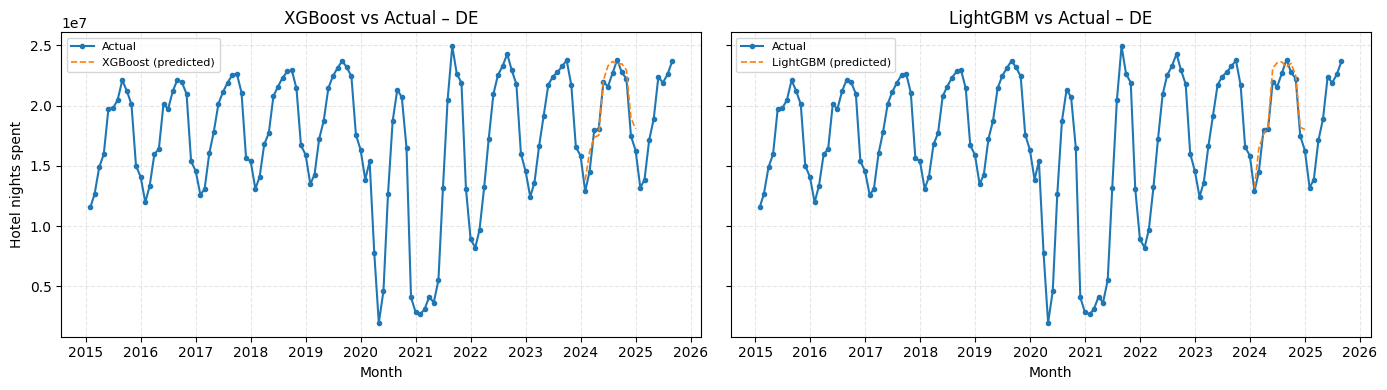

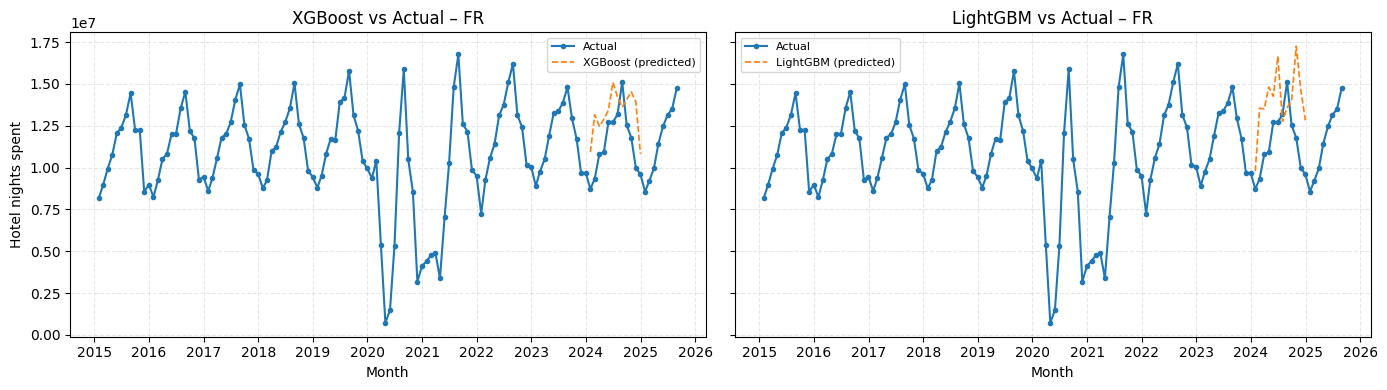

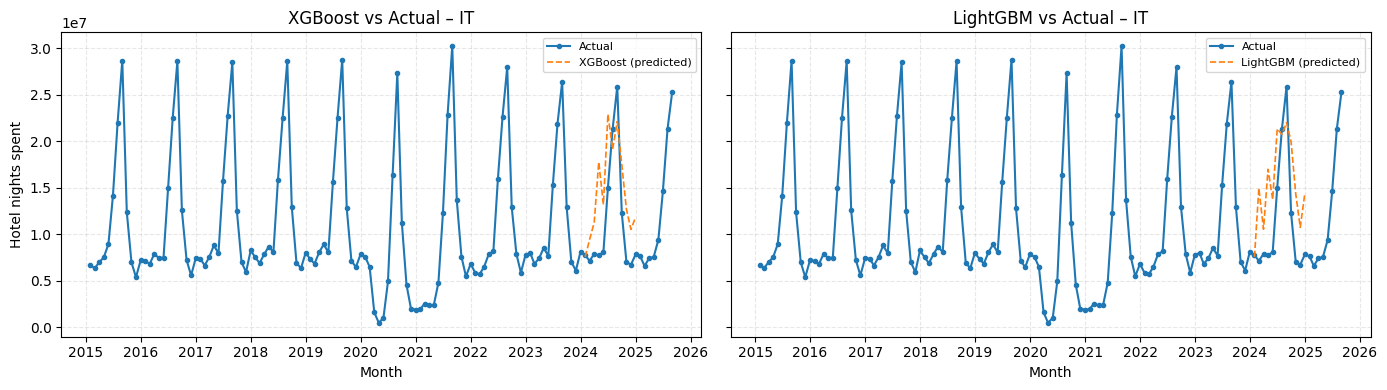

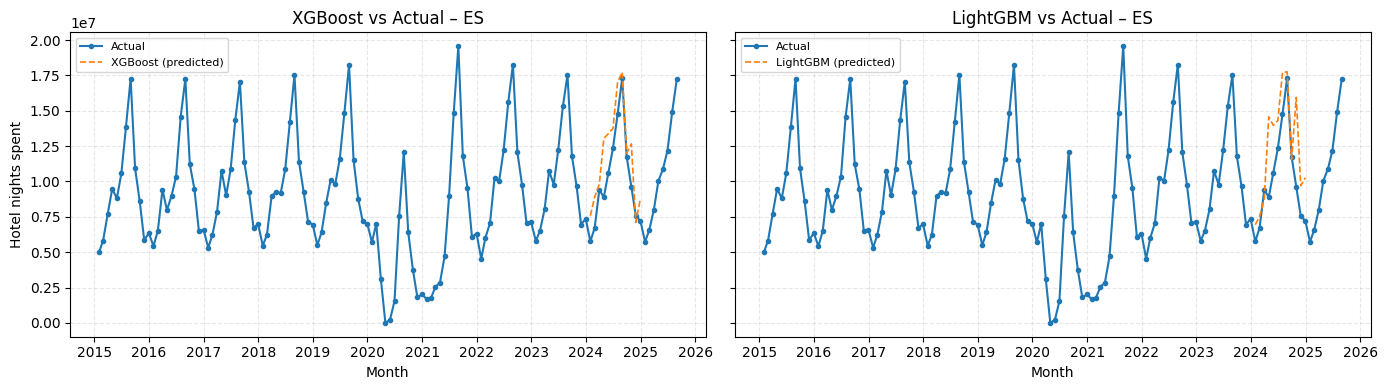

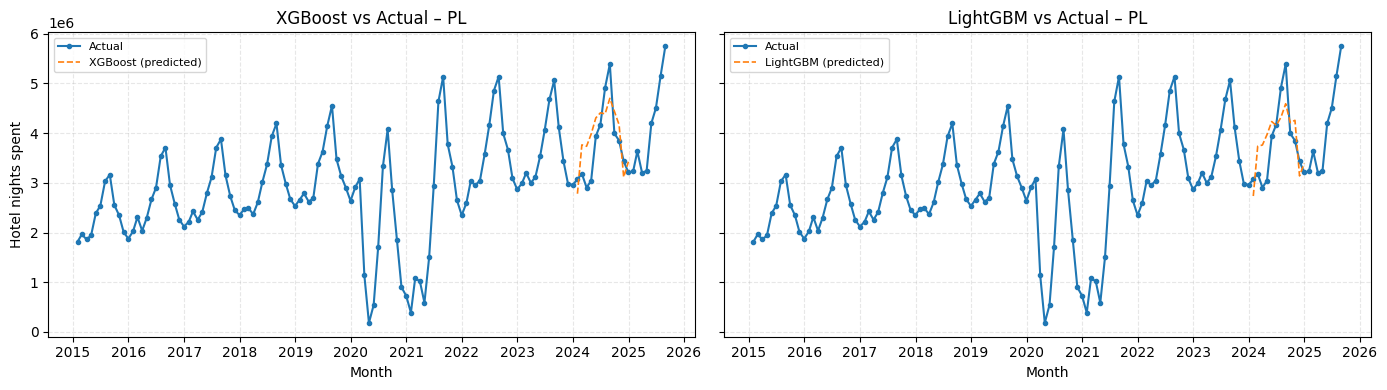

In [15]:
# %% -----------------------------------------------
# STEP 14 — VISUALIZE XGBOOST AND LIGHTGBM FORECASTS - TOP 5 COUNTRIES
# -----------------------------------------------

# --- Select top 5 countries dynamically ---
top_regions = (
    df.groupby("region")["nights_spent"]
    .mean()
    .nlargest(5)
    .index
)
print(f"[INFO] Plotting ML forecasts for: {list(top_regions)}")

# --- Use simple Matplotlib defaults (no seaborn overrides) ---
plt.rcdefaults()

for c in top_regions:
    subset = df.query("region == @c").sort_values("month")

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    # --- Left: XGBoost ---
    axes[0].plot(
        subset["month"], subset["nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_xgb" in subset:
        axes[0].plot(
            subset["month"], subset["yhat_xgb"],
            label="XGBoost (predicted)", linestyle="--", lw=1.2
        )
    axes[0].set_title(f"XGBoost vs Actual – {c}")
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Hotel nights spent")
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3, linestyle="--")
    axes[0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- Right: LightGBM ---
    axes[1].plot(
        subset["month"], subset["nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_lgbm" in subset:
        axes[1].plot(
            subset["month"], subset["yhat_lgbm"],
            label="LightGBM (predicted)", linestyle="--", lw=1.2
        )
    axes[1].set_title(f"LightGBM vs Actual – {c}")
    axes[1].set_xlabel("Month")
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3, linestyle="--")
    axes[1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()
    plt.show()

### **Part 3 — Cross-Model Evaluation and Comparison**

### 7. Evaluate All Models (2024 RMSE/MAE)

In [16]:
# %% -----------------------------------------------
# STEP 15 — EVALUATE ALL MODELS (NAIVE, ARIMAX, SARIMAX, XGB, LGBM)
# -----------------------------------------------

# --- Select available model prediction columns ---
pred_cols = [c for c in ["yhat_naive", "yhat_arimax", "yhat_sarimax", "yhat_xgb", "yhat_lgbm"] if c in df.columns]
print(f"[INFO] Available prediction columns: {pred_cols}")

# --- Focus on validation period (2024) ---
mask_2024 = (df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")
df_eval = df.loc[mask_2024].copy()

# --- Define metrics ---
def rmse(y, yhat):
    m = (~y.isna()) & (~yhat.isna())
    return np.sqrt(mean_squared_error(y[m], yhat[m])) if m.sum() else np.nan

def mae(y, yhat):
    m = (~y.isna()) & (~yhat.isna())
    return mean_absolute_error(y[m], yhat[m]) if m.sum() else np.nan

# --- Compute region-level metrics ---
eval_tbl_all = (
    df_eval.groupby("region", group_keys=False)
           .apply(lambda d: pd.Series({
               **{f"RMSE_{m}": rmse(d["nights_spent"], d[m]) for m in pred_cols},
               **{f"MAE_{m}":  mae(d["nights_spent"], d[m])  for m in pred_cols},
           }))
           .reset_index()
)

# --- Save and summarize ---
EVAL_PATH = REPORTS / "adv_model_metrics_summary.csv"
eval_tbl_all.to_csv(EVAL_PATH, index=False)

print(f"💾 Evaluation metrics saved → {EVAL_PATH.resolve()}")
print(f"✅ Regions evaluated: {eval_tbl_all['region'].nunique()}")

# --- Mean metrics across all countries ---
mean_metrics = eval_tbl_all.mean(numeric_only=True).round(2)
print("\n📊 Mean RMSE / MAE across ALL EU Countries (2024):")
display(mean_metrics)

[INFO] Available prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
💾 Evaluation metrics saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/adv_model_metrics_summary.csv
✅ Regions evaluated: 26

📊 Mean RMSE / MAE across ALL EU Countries (2024):


RMSE_yhat_naive      636971.03
RMSE_yhat_arimax     425549.87
RMSE_yhat_sarimax    198014.55
RMSE_yhat_xgb        617707.35
RMSE_yhat_lgbm       758325.61
MAE_yhat_naive       469795.95
MAE_yhat_arimax      333786.47
MAE_yhat_sarimax     159411.65
MAE_yhat_xgb         531980.15
MAE_yhat_lgbm        641367.68
dtype: float64

### 8. Visualize Overall Model Accuracy

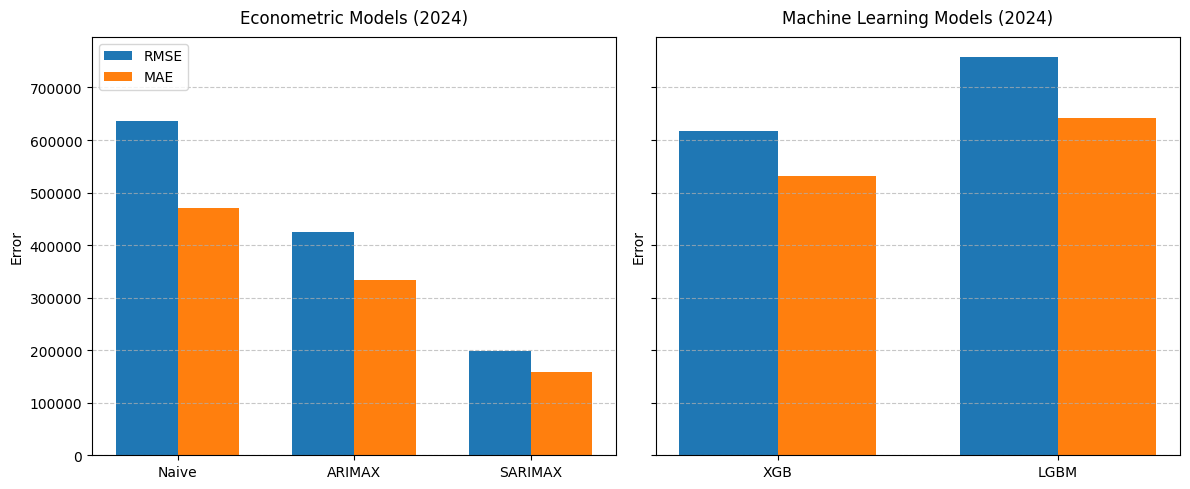

In [17]:
# %% -----------------------------------------------
# STEP 16 — VISUALIZATION: MODEL ACCURACY COMPARISON
# -----------------------------------------------

# --- Compute mean metrics if not already in memory ---
if "mean_metrics" not in locals():
    mean_metrics = eval_tbl_all.mean(numeric_only=True).round(2)

# --- Model categories ---
econ_models = ["Naive", "ARIMAX", "SARIMAX"]
ml_models   = ["XGB", "LGBM"]

# --- Colors ---
COLOR_RMSE = "#1f77b4"
COLOR_MAE  = "#ff7f0e"

def plot_group(ax, models, title):
    rmse_vals = [mean_metrics.get(f"RMSE_yhat_{m.lower()}", np.nan) for m in models]
    mae_vals  = [mean_metrics.get(f"MAE_yhat_{m.lower()}", np.nan)  for m in models]
    x = np.arange(len(models))
    width = 0.35

    ax.bar(x - width/2, rmse_vals, width, label="RMSE", color=COLOR_RMSE)
    ax.bar(x + width/2, mae_vals,  width, label="MAE",  color=COLOR_MAE)
    ax.set_title(title, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel("Error")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# --- Create figure ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

plot_group(axes[0], econ_models, "Econometric Models (2024)")
plot_group(axes[1], ml_models, "Machine Learning Models (2024)")

axes[0].legend(loc="upper left")
plt.tight_layout()
plt.show()

### 9. Insights and Next Steps  

#### 🧾 Summary  

This notebook refined the forecasting pipeline with **SARIMAX, XGBoost,** and **LightGBM,** providing improved seasonal accuracy and richer nonlinear modeling.

**Highlights:**  
- Extended ARIMAX to **SARIMAX** to capture seasonality and cyclical demand.  
- Added **LightGBM,** complementing XGBoost for efficiency and scalability.  
- Unified all model outputs (`yhat_naive`, `yhat_arimax`, `yhat_sarimax`, `yhat_xgb`, `yhat_lgbm`) in one file.  
- SARIMAX achieved the lowest RMSE and MAE across all EU regions in 2024.  

**Inputs:**  
📁 `../data/processed/hotel_features.csv`

**Output:**  
📁 `../outputs/reports/adv_model_metrics_summary.csv`  
📁 `../outputs/models/sarimax/sarimax_<country>.pkl`  
📁 `../outputs/models/pipe_xgb.pkl, outputs/models/pipe_lgbm.pkl`  
📁 `../data/processed/hotel_predictions.csv`  
📁 `../data/processed/train_features_for_shap.csv`  

**Next Steps → Notebook 4:**  
Interpret model predictions using **SHAP values** and econometric regressions to identify key drivers of hotel demand.